In [1]:
#%%
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Jan 3 2021

@author: aidanrogers
"""

import mne

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt
import os, sys
#import keyboard
import time
import pathlib
from autoreject import AutoReject
import os
from os.path import join
from os import chdir

#mne.viz.set_3d_options(antialias=False, depth_peeling = False, smooth_shading = False)
#mne.viz.set_3d_backend('pyvista')

if os.name == 'posix': # linux
    D_Drive = '/mnt/d/Aidan'
    root_dir = '~'
    SUBJECTS_DIR = os.getenv('SUBJECTS_DIR')
    FREESURFER_HOME = os.getenv('FREESURFER_HOME')
elif os.name == 'nt': # windows
    D_Drive = 'D:\Aidan'
    root_dir = join("C:\\","Users","aar40","AppData","Local","Packages",
                           "CanonicalGroupLimited.Ubuntu22.04LTS_79rhkp1fndgsc","LocalState","rootfs")
    FREESURFER_HOME = join(root_dir, "usr", "local", "freesurfer", "7.3.2")
    SUBJECTS_DIR = join(FREESURFER_HOME,'subjects')
    os.environ['SUBJECTS_DIR'] = SUBJECTS_DIR
    os.environ['FREESURFER_HOME'] = FREESURFER_HOME
else:
    raise SystemError('Unknown system os')

mne.viz.set_3d_options(antialias=False)
mne.viz.set_3d_backend('pyvista')

#cd D:\Aidan
%matplotlib qt

#D:/Aidan/E1/BrainVision_Recorder/E1_TwoBeeps.vhdr
#124_Ch_Test.bvef

def sleeper():
    """
    Attempted function to streamline code
    
    function was used to try and cause pauses between opening plots 
    for EEG analysis

    """
    while True:
        num = 300
        
        try:
            num = float(num)
        except ValueError:
            print('Please enter in a number.\n')
            continue
        print('before: %s' % time.ctime())
        time.sleep(num)
        print('After: %s\n' % time.ctime())
    

def make_montage():
    """
    creates montage, identifies and finds the montage, then makes sure data 
    is properly aligned with electrode placement we want 

    Parameters
    ----------
    montage_fname : montage
        DESCRIPTION - electrode placement on head of specific subj (128)
    subj_num : TYPE
        DESCRIPTION - the subject # - who's file are we accessing?

    Returns
    -------
    montage : montage
        DESCRIPTION  - aligned montage
    raw : raw
        DESCRIPTION - bandpass filtered raw data file

    """
    # have to be in same directory as the file ur looking at to access b/c MNE
    os.chdir(D_Drive)
    
    
    montage_fname = input ('Are you using a custom (C) or default (D) montage/electrode placement ')
    subj_num = input('what subject # are you analyzing: ')
    
    
    # to be used for the inverse solution (making the bem, coregistraton, covariance etc)
    global subj 
    subj = 'E'+ subj_num
    global subject
    subject = subj
    
    # to be used for the inverse solution (making the bem, coregistraton, covariance etc)
    # global subjects_dir
    # global FREESURFER_HOME
    # subjects_dir = 'C:/Users/aar40/Desktop/share/freesurfer/subjects'
    # FREESURFER_HOME = 'C:/Users/aar40/Desktop/share/freesurfer'

    # mne.set_config(key = subjects_dir, value = 'E46')
    
    # to identify the correct montage/electrode config
    if (montage_fname == 'D'):
        montage_name = '124_Ch_Test.bvef'
        #load default montage / electrode position
        montage = mne.channels.read_custom_montage(montage_name)
    elif (montage_fname == 'C'):
        #load custom montage / electrode position
        montage_name = traverse('CapTrak', subj, subj, '.bvct')
        montage = mne.channels.read_dig_captrak(montage_name)
    else:
        print('invalid input')

    
    
    
    vhdr1 = 'TwoBeeps' #change these to change what type of file you're analyzinbg
    vhdr2 = '.vhdr'
    vhdr_fname = traverse(os.sep + 'BrainVision_Recorder', subj, vhdr1, vhdr2)
   # vhdr_fname = ''

    #vhdr_path = 'D:\Aidan/' + subj + '/BrainVision_Recorder/'     
    #vhdr_fname = (filenames for _,_,filenames in os.walk(vhdr_path) if vhdr1 & vhdr2 in filenames)
    raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True)
    
    #Channel renaming dictionary for TwoBeeps subjs E2 - 27
    if ((int(subj_num) > 1) & (int(subj_num) < 28 )):
        raw = load_data_skewed(raw);
    
    if (subj != 'E1'): #set eog
        raw.set_channel_types({'125':'eog','126':'eog','127':'eog','128':'eog'})
        
    #apply bandpass filter, set frequency bands
    raw.filter(0.5,40)
    
    #after filtering, remove bad channels in qt plot
    raw.plot()
    # print("wait")
    # wait = input('Press a key to continue: ')
    # print("continue")
    #cont = keyboard.read_key()
    #raw.set_eeg_reference('average')
    # raw.set_eeg_reference('average', projection=True)

    # raw.set_montage(montage)
    # raw.save(pathlib.Path('/mnt/d/Aidan/' + subj + '/Digitization') / 'Captrak_Digitization.fif', overwrite = True)
    
    return montage, raw

def traverse(where, subj, vhdr1, vhdr2):
    global vhdr_fname_1
    # for dirpath, dirnames, filenames in os.walk('D:\Aidan/' + subj + where):
    for dirpath, dirnames, filenames in os.walk(D_Drive + os.sep + subj + os.sep + where):
        for name in filenames:
            if vhdr1 in name:
                if vhdr2 in name:
                    vhdr_fname_1 = dirpath + os.sep + name 
                    print(vhdr_fname_1)
                    print(type(vhdr_fname_1))
                    return vhdr_fname_1

def load_data_skewed(raw):
    '''
    takes in raw data file and makes sure the channels (which were missnamed)
    are re-aligned given a dictionary

    Parameters
    ----------
    raw : raw
        DESCRIPTION - raw data file

    Returns
    -------
    raw : raw
        DESCRIPTION - data aligned with correct electrode orientation

    '''
    #Load in EEG file
    # raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True)

    #Channel renaming dictionary for TwoBeeps subjs E2 - 27
    #1-32:97:128, 33-64:65-96, 65-96:33-64. 97-128:1-32
    name_dict = {'1':'97','2':'98','3':'99','4':'100','5':'101','6':'102',
             '7':'103','8':'104','9':'105','10':'106','11':'107','12':'108',
             '13':'109','14':'110','15':'111','16':'112','17':'113',
             '18':'114','19':'115','20':'116','21':'117','22':'118',
             '23':'119','24':'120','25':'121','26':'122','27':'123',
             '28':'124','29':'125','30':'126','31':'127','32':'128','33':'65',
             '34':'66','35':'67','36':'68','37':'69','38':'70','39':'71',
             '40':'72','41':'73','42':'74','43':'75','44':'76','45':'77',
             '46':'78','47':'79','48':'80','49':'81','50':'82','51':'83',
             '52':'84','53':'85','54':'86','55':'87','56':'88','57':'89',
             '58':'90','59':'91','60':'92','61':'93','62':'94','63':'95',
             '64':'96','65':'33','66':'34','67':'35','68':'36','69':'37',
             '70':'38','71':'39','72':'40','73':'41','74':'42','75':'43',
             '76':'44','77':'45','78':'46','79':'47','80':'48','81':'49',
             '82':'50','83':'51','84':'52','85':'53','86':'54','87':'55',
             '88':'56','89':'57','90':'58','91':'59','92':'60','93':'61',
             '94':'62','95':'63','96':'64','97':'1','98':'2','99':'3',
             '100':'4','101':'5','102':'6','103':'7','104':'8','105':'9',
             '106':'10','107':'11','108':'12','109':'13','110':'14',
             '111':'15','112':'16','113':'17','114':'18','115':'19',
             '116':'20','117':'21','118':'22','119':'23','120':'24',
             '121':'25','122':'26','123':'27','124':'28','125':'29',
             '126':'30','127':'31','128':'32'}
    
    #list to reorder channels after renaming
    order_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13',
                  '14','15','16','17','18','19','20','21','22','23','24','25',
                  '26','27','28','29','30','31','32','33','34','35','36','37',
                  '38','39','40','41','42','43','44','45','46','47','48','49',
                  '50','51','52','53','54','55','56','57','58','59','60','61',
                  '62','63','64','65','66','67','68','69','70','71','72','73',
                  '74','75','76','77','78','79','80','81','82','83','84','85',
                  '86','87','88','89','90','91','92','93','94','95','96','97',
                  '98','99','100','101','102','103','104','105','106','107',
                  '108','109','110','111','112','113','114','115','116','117',
                  '118','119','120','121','122','123','124','125','126','127',
                  '128']

    #rename channels based on above dictionary
    raw.rename_channels(name_dict)
    
    #reorder channels to go sequentially from 1 to 128
    raw.reorder_channels(order_list)
    
    return raw
    
    
def set_data(raw, montage):
    '''
    common average reference.
    take the average signal across all electrodes and take it off the top
    reduces noise by 30% - on average
    '''
    #set reference to average    
    raw.set_eeg_reference('average', projection=True)
    
    #plot data again to remove any remaining bad channels
    raw.plot()
    
    #cont = keyboard.read_key()


    return raw
    

def EOG_check(raw2, ica):
    '''
    1. regenerates epochs, and evoked (avg epochs)
    2. uses find_bads_eog locations and saves those voltages and time periods
    3. plot functions (some are commented out)
    4. ica.exclude.extend(eog_indices) --> 
    --> plots newly excluded indices as a copy of raw data
    5. display new ERP (doesn't save the data to the main raw file)
    '''
    eog_epochs=mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.1))
    # eog_epochs.plot_image(combine='mean')
    # eog_epochs.average().plot_joint()
    eog_average = eog_epochs.average()

    # ica.exclude = []
    # find which ICs match the EOG pattern
    # eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
    [eog_indices,eog_scores]=ica.find_bads_eog(eog_epochs)
    
    # barplot of ICA component "EOG match" scores
    # ica.plot_scores(eog_scores, exclude=eog_indices)
    
    # plot diagnostics
    #ica.plot_properties(raw2, picks=eog_indices)
    
    # plot ICs applied to raw data, with EOG matches highlighted
    # ica.plot_sources(raw2, show_scrollbars=True)
    
    # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
    ica.plot_sources(eog_average)
    
    #ica.plot_properties(eog_epochs, picks=eog_indices, psd_args={'fmax': 35.},
    #                image_args={'sigma': 1.})
    #print(ica.labels_)
    
    ica.plot_overlay(eog_average, exclude=eog_indices, show=True, title = 'average_indices removed')
    ica.plot_overlay(inst = raw2, exclude = eog_indices, title = 'raw before and blink detection')

    
    ica.exclude.extend(eog_indices)
    
    reconst_raw = raw2.copy()
    ica.apply(inst=reconst_raw)
    
    erp(reconst_raw, montage)    
    
    return reconst_raw
    

def EOG_check_ar(epochs_ar, ica):
    '''
    1. regenerates epochs, and evoked (avg epochs)
    2. uses find_bads_eog locations and saves those voltages and time periods
    3. plot functions (some are commented out)
    4. ica.exclude.extend(eog_indices) --> 
    --> plots newly excluded indices as a copy of raw data
    5. display new ERP (doesn't save the data to the main raw file)
    '''
    evoked_ar = epochs_ar.average()

    [eog_indices,eog_scores]=ica.find_bads_eog(epochs_ar)

    # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
    ica.plot_sources(evoked_ar)
    
    ica.exclude.extend(eog_indices)
    
    reconst_raw = epochs_ar.copy()
    ica.apply(inst=reconst_raw)
    
    evoked = reconst_raw.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    
    return evoked, reconst_raw
        
    
def EOG_annot(raw2, ica):
    '''
    annotates data for when a bad blink occurs
        - occurences (when EOG channels are correlated with specific electrode channel activity)
    
    Current Issues:
        - overwriting stimulus annotations from original data

    '''
    # make a file, that has the file with the components rempved
    #     then plot that clean data
    #     0 is the ocular event
    # you can reconstruct your, 
    # Review removing the ICA components on their own
    #     project components back into the data
    #         then subtract it fromthe data
    #             have aw and then signal, then put them back
    #             put the data back into original format, then you add it all together,
    #             subtract tthe components you don't want
                

    eog_events = mne.preprocessing.find_eog_events(raw2)
    onsets = eog_events[:, 0] / raw.info['sfreq']-0.25 
    #take all the indices, divided by the sample rate, 2500hz,-0.25
    durations = [0.6] * len( eog_events)
    print(len(eog_events))
    descriptions = ['bad blink'] * len( eog_events)
    blink_annot = mne.Annotations(onsets, durations, descriptions,
                                  orig_time=raw.info['meas_date'])
    raw2.set_annotations(blink_annot)
    eeg_picks = mne.pick_types(raw2.info, meg=False, eeg=True)
    raw2.plot(events= eog_events, order=eeg_picks)
    #raw.plot(events= eog_indices, order=eeg_picks)

    return raw2


def erp_blink(raw, montage):
    '''
    takes annotated data, wherever bad blink is listed
    removes the annotation and then plots data

    '''
    #get events and their IDs from annotations in recorded eeg data
    getData = mne.events_from_annotations(raw, event_id={'bad blink':998})


    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=True)
    
    #create ERP
    evoked = epochs.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    #cont = keyboard.read_key()
    
    
def erp(raw, montage):  
    '''
    1. gets stimuli events from annotations in OG data set
    2. separate the ID's
    3. generate epochs
    (slices of time from tmin to tmax based around stimuli occurences)
    4. plot the average epoch (evoked)
    5. set evoked plot to match the electrode placements
    6. plot topographic map of the average epoch centered on the stimuli
    
    plots the ERP #5

    '''
    #get events and their IDs from annotations in recorded eeg data
    getData = mne.events_from_annotations(raw, event_id={'Stimulus/S  1':1,
                                                         'Stimulus/S  2':2,})
    #                                                      'Stimulus/S  3':3,
    #                                                      'Stimulus/S  4':4})
    # print(getData[0])
    # print(getData[1])
    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=False)
    
    #create ERP
    evoked = epochs.average()
    evoked.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked.plot_topomap(times=times, ch_type='eeg')
    
    return epochs
    #cont = keyboard.read_key()
 
    
def ica_func(raw2):
    '''
    does ICA on the EEG data

    '''
    #define ica method, default fastica
    ica = mne.preprocessing.ICA(method="fastica")
    
    #fit data to ica
    ica.fit(raw2)
    

    #plot ica components, set inst=data to make plots interactive
    ica.plot_components(ch_type='eeg', inst=raw2) #, topomap_args={'data':raw})
    
    #cont = keyboard.read_key()
    # reconst_raw = raw2.copy()
    # ica.apply(inst=reconst_raw)
    

    # ica.plot_overlay(inst = reconst_raw)

    return ica

def autorej(epochs):
    
    n_interpolates = np.array([1, 4, 32])
    consensus_percs = np.linspace(0, 1.0, 11)
    ar = AutoReject(n_interpolates, consensus_percs, random_state = 26042021)
    
    ar.fit(epochs)
    
    epochs_ar, reject_log = ar.transform(epochs, return_log = True)
    
    #reject_log.plot_epochs(epochs, scalings = {"eeg":1e-4})
    
    evoked_ar = epochs_ar.average()
    evoked_ar.plot()
    
    #set ERP to custom montage and plot topoplots
    # evoked_ar.set_montage(montage)
    times = np.arange(0.0, 0.31, 0.05)
    evoked_ar.plot_topomap(times=times, ch_type='eeg')

    return epochs_ar

def ICA_auto_rej(epochs_ar):
    '''
    does ICA on the EEG data

    '''
    #define ica method, default fastica
    ica = mne.preprocessing.ICA(method="fastica")
    
    #fit data to ica
    ica.fit(epochs_ar)
    

    #plot ica components, set inst=data to make plots interactive
    ica.plot_components(ch_type='eeg', inst=epochs_ar) #, topomap_args={'data':raw})
    
    #cont = keyboard.read_key()
    # reconst_raw = raw2.copy()
    # ica.apply(inst=reconst_raw)
    

    # ica.plot_overlay(inst = reconst_raw)

    return ica


## COREGISTRATION STEPS

def BEM(SUBJECTS_DIR):
    surfaces = mne.bem.make_watershed_bem(subj, subjects_dir = SUBJECTS_DIR)
    surfaces = mne.bem.make_scalp_surfaces(subj, subjects_dir = SUBJECTS_DIR)
    mne.viz.plot_bem(subject = subj, subjects_dir = SUBJECTS_DIR, orientation = 'coronal', show = True, show_indices=True, mri = 'T1.mgz', show_orientation=True)
    mne.bem.make_watershed_bem(subject=subj, subjects_dir=SUBJECTS_DIR, overwrite=True, volume='T1', atlas=False, gcaatlas=False, preflood=None, show=False, copy=False, T1=None, brainmask='ws.mgz', verbose=None)


def covariance(reconst_raw):
    '''
    compute covariance from fresh raw data and epochs

    Returns
    -------
    noise_cov : TYPE
        DESCRIPTION.
    fig_cov : TYPE
        DESCRIPTION.
    fig_spectra : TYPE
        DESCRIPTION.

    '''
    noise_cov = mne.compute_covariance(reconst_raw, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)
    noise_cov = mne.cov.regularize(noise_cov, raw2.info)
    
    fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw2.info)
    
    
    evoked = reconst_raw.average()
    evoked.plot_white(noise_cov, time_unit='s')
    
    
    return noise_cov, fig_cov, fig_spectra, evoked

def covariance_raw():
    '''
    compute covariance from fresh raw data and epochs

    Returns
    -------
    noise_cov : TYPE
        DESCRIPTION.
    fig_cov : TYPE
        DESCRIPTION.
    fig_spectra : TYPE
        DESCRIPTION.

    '''
    montage, raw =  make_montage()
    
    getData = mne.events_from_annotations(raw, event_id={'Stimulus/S  1':1,
                                                          'Stimulus/S  2':2,})

    events = getData[0]
    event_id = getData[1]

    tmin = -0.5
    tmax = 1.0
    baseline = (-0.5, -0.1)
    
    #create epochs with baseline subtraction 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, 
                        tmax=tmax, proj=True, baseline=baseline, preload=True,
                        reject_by_annotation=False)
    
    # epochs.save(pathlib.Path('D:/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif', overwrite = True) #to do co-registration, have to do file path so gui.coreg can take as input
    epochs.save(pathlib.Path('/mnt/d/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif', overwrite = True) #to do co-registration, have to do file path so gui.coreg can take as input
    
    #noise_cov = mne.compute_covariance(reconst_raw, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)
    noise_cov = mne.compute_covariance(epochs, tmax = 0, method = ['shrunk', 'empirical'], rank = None, verbose = True)

    noise_cov = mne.cov.regularize(noise_cov, epochs.info)
    
    fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)
    
    
    evoked = epochs.average()
    evoked.plot_white(noise_cov, time_unit='s')
    
    
    return noise_cov, fig_cov, fig_spectra, evoked


def Co_register(SUBJECTS_DIR):
    epochs_fname = pathlib.Path('/mnt/d/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif'
    data = pathlib.Path('/mnt/d/Aidan/' + subj + '/Digitization') / 'Captrak_Digitization.fif'
    # epochs_fname = pathlib.Path('D:/Aidan/' + subj +'/Epochs') / 'epochs_for_source_epo.fif'
    mne.gui.coregistration(subject = subj, subjects_dir=SUBJECTS_DIR, inst = data)

#cd D:\Aidan
#%matplotlib qt

def fsa_average(src, SUBJECTS_DIR):
    home_path = '/mnt/d/Aidan'
    data_path = join(home_path, 'data/')
    save_dir_averages = data_path + 'Grand_Averages/Epochs'
    save_dir = data_path + 'Grand_Averages'
    fsa_average_file = SUBJECTS_DIR + '/fsaverage'
    #stc_morph = mne.morph_data(subj, 'fsaverage', SUBJECTS_DIR, n_jobs=-1)
    src_morph = mne.morph_source_spaces(src_from = src, subject_to='fsaverage', subjects_dir = SUBJECTS_DIR, surf = 'inflated')
    stcs = mne.read_source_estimates(subject = subj,fname = save_dir)
    
    #fwd = mne.make_forward_solution(info, trans=trans, src=src_morph, bem=bem_sol, meg=False, eeg=True, mindist=5.0, n_jobs=1)
    
def evoked_grand_average(evoked_data_all):
    
    home_path = '/mnt/d/Aidan'
    data_path = join(home_path, 'data/')
    save_dir_averages = data_path + 'Grand_Averages/Epochs'
    save_dir = data_path + 'Grand_Averages'
    method = 'eLORETA'
    
def make_morphed_data_average(subject_list):
    Inv_path = '/mnt/d/Aidan/Grand_Averages/Inv_op'
    Evoked_path = '/mnt/d/Aidan/Grand_Averages/Epochs'
    
    subj = subject_list[0]
    subj_inv_1 = mne.minimum_norm.read_inverse_operator(Inv_path + '/' + subj + 'inv.fif')
    subj_ev_1 = mne.read_evokeds(Evoked_path + '/' + subj + '_raw_for_ave.fif')
    stc = mne.minimum_norm.apply_inverse(subj_ev_1, subj_ev_1, method = 'eLORETA')
    average_source_space = stc.copy() 
        
    for i in range (1, len(subject_list)):
        subj = subject_list[i]
        subj_inv = mne.minimum_norm.read_inverse_operator(Inv_path + '/' + subj + 'inv.fif')
        subj_ev = mne.read_evokeds(Evoked_path + '/' + subj + '_raw_for_Gaverage.fif')
        stc = mne.minimum_norm.apply_inverse(subj_ev, subj_ev, method = 'eLORETA')
        average_source_space.data += stc.data
        
    # subj1 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E25' + 'inverse_op.fif')
    # subj2 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E29' + 'inverse_op.fif')
    # subj3 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E30' + 'inverse_op.fif')
    # subj4 = mne.minimum_norm.read_inverse_operator(Inv_path + 'E31' + 'inverse_op.fif')
    # subj1_ev = mne.read_evokeds(Evoked_path + 'E25' + '_raw_for_Gaverage.fif')
    # mne.minimum_norm.apply_inverse(reconst_evoked, inv_morph, method = 'eLORETA')
    
    return average_source_space

    
def make_average_stc(subject_list):
    sc_path = '/mnt/d/Aidan/Grand_Averages/Source_Estimates'
    
    subj = subject_list[0]
    stc_lh_1 = mne.read_source_estimate(sc_path + '/' + subj + '_src-lh.stc', subj)
    stc_rh_1 = mne.read_source_estimate(sc_path + '/' + subj + '_src-rh.stc', subj)
    average_lh = stc_lh_1.copy() 
    average_rh = stc_rh_1.copy() 

    for i in range (1, len(subject_list)):
        subj = subject_list[i]
        stc_lh = mne.read_source_estimate(sc_path + '/' + subj + '_src-lh.stc', subj)
        stc_rh = mne.read_source_estimate(sc_path + '/' + subj + '_src-rh.stc', subj)
        average_lh += stc_lh_1
        average_rh += stc_rh_1
        
    average_rh = average_rh/(len(subject_list))
    average_lh = average_lh/(len(subject_list))

    return average_lh, average_rh



Using pyvistaqt 3d backend.



In [ ]:
export FS_LICENSE='/usr/local/freesurfer/7.3.2/license.txt'


In [108]:
montage, raw = make_montage()

D:\Aidan\E13\CapTrak\E13_124ch_180219.bvct
<class 'str'>
D:\Aidan\E13\\BrainVision_Recorder\E13_TwoBeeps_210219.vhdr
<class 'str'>
Extracting parameters from D:\Aidan\E13\\BrainVision_Recorder\E13_TwoBeeps_210219.vhdr...
Setting channel info structure...
Reading 0 ... 1045999  =      0.000 ...   418.400 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    4.2s finished


Channels marked as bad:
none


In [3]:
raw2 = set_data(raw, montage) #common average reference

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [4]:
raw2.set_montage(montage)

<RawBrainVision | E13_TwoBeeps_210219.eeg, 128 x 1046000 (418.4 s), ~1021.7 MB, data loaded>

In [5]:
epochs = erp(raw2, montage)


Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  2']
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 200 events and 3751 original time points ...
0 bad epochs dropped


In [6]:
epochs.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs') / 'epochs_for_source_epo.fif', overwrite = True) #to do co-registration, have to do file path so gui.coreg can take as input


Overwriting existing file.


In [ ]:
#to change the plot if channels still need to be removed
raw2.plot()

In [7]:
#AUTOREJ ROUTE:
epochs_ar = autorej(epochs)

c:\Users\aar40\Anaconda3\envs\mne\lib\site-packages\autoreject\utils.py:65: UserWarning: 28 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


Running autoreject on ch_type=eeg


c:\Users\aar40\Anaconda3\envs\mne\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Creating augmented epochs : 96/96 [00:20<00:00,    4.69it/s]
100%|██████████| Computing thresholds ... : 96/96 [08:08<00:00,    5.09s/it]





































































100%|██████████| Repairing epochs : 200/200 [00:01<00:00,  159.86it/s]








































































































































































100%|██████████| Repairing epochs : 200/200 [00:03<00:00,   54.88it/s]






















100%|██████████| Fold : 10/10 [01:02<00:00,    6.27s/it]








































































































































Estimated consensus=0.50 and n_interpolate=32





































































































































































100%|██████████| Repairing epochs : 200/200 [00:03<00:00,   57.24it/s]


Dropped 41 epochs: 37, 39, 52, 53, 54, 57, 58, 59, 60, 64, 68, 70, 71, 73, 75, 76, 81, 82, 95, 96, 98, 110, 114, 120, 124, 125, 126, 127, 128, 129, 132, 133, 138, 149, 153, 161, 162, 172, 185, 193, 199


In [8]:
epochs_ar.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs') / 'AR_epochs.fif', overwrite = True)

C:\Users\aar40\AppData\Local\Temp\ipykernel_11784\1656669456.py:1: RuntimeWarning: This filename (D:\Aidan\E13\Epochs\AR_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs') / 'AR_epochs.fif', overwrite = True)


In [9]:
ica = ICA_auto_rej(epochs_ar)


Fitting ICA to data using 96 channels (please be patient, this may take a while)


C:\Users\aar40\AppData\Local\Temp\ipykernel_11784\4170453209.py:512: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_ar)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by non-zero PCA components: 95 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 151.2s.


    Applying projection operator with 1 vector (pre-whitener application)
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=99, n_times=1046000
    Range : 0 ... 1045999 =      0.000 ...   418.400 secs
Ready.


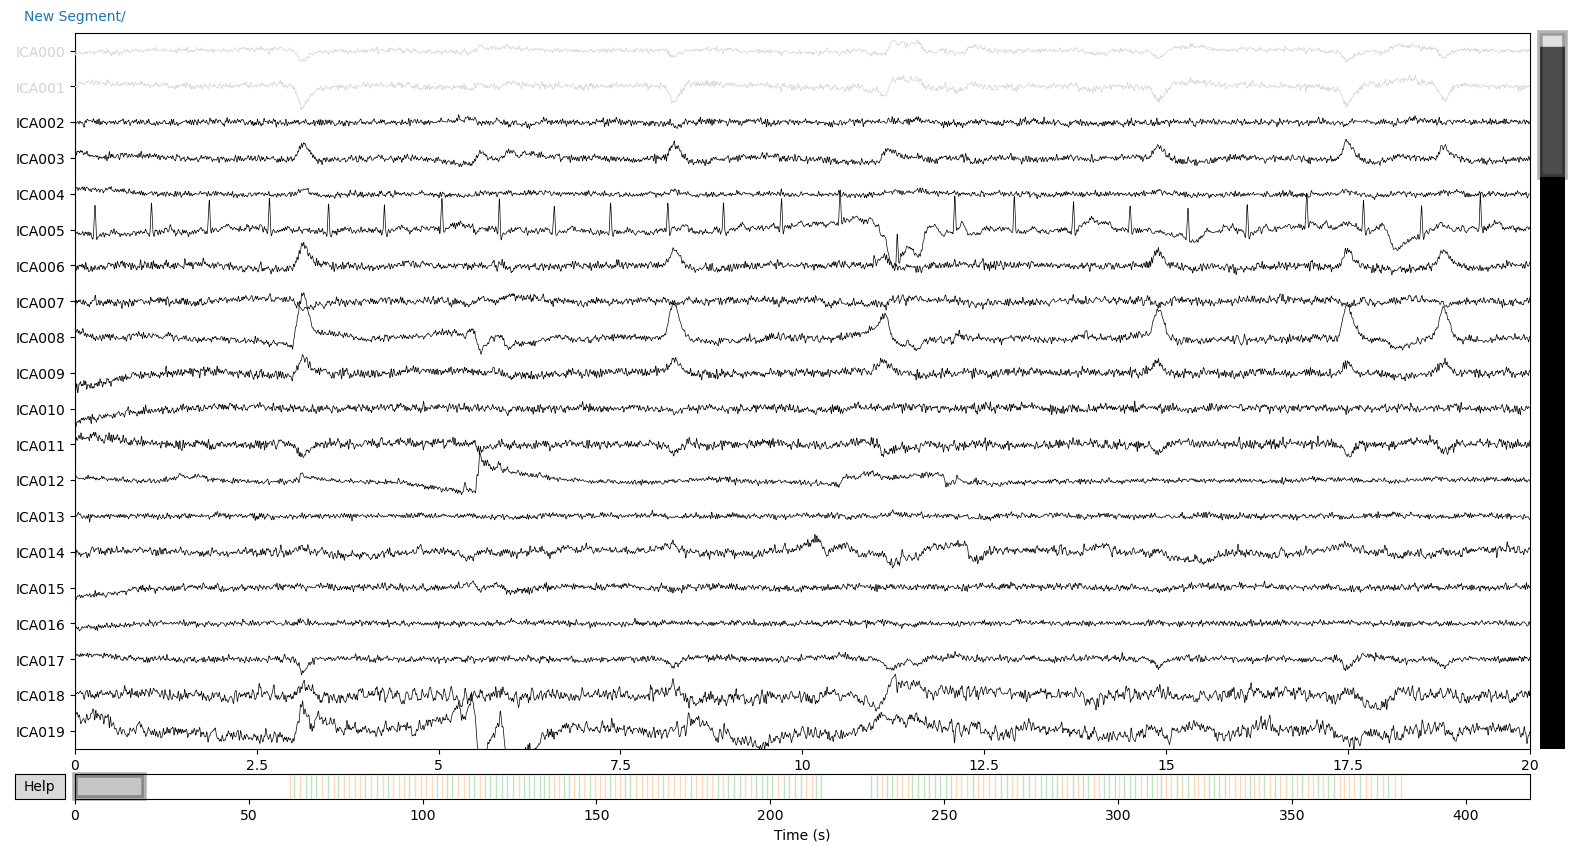

In [12]:
ica.plot_sources(epochs_ar, show_scrollbars=True)     # to plot ICA vs time
ica.plot_sources(raw2, show_scrollbars=True)     # to plot ICA vs time


In [14]:
reconst_evoked, reconst_raw = EOG_check_ar(epochs_ar, ica)

Using EOG channels: 125, 126, 127, 128
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
    Applying projection operator with 1 vector (pre-whitener application)
Applying ICA to Epochs instance


C:\Users\aar40\AppData\Local\Temp\ipykernel_11784\4170453209.py:329: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(inst=reconst_raw)


    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (95 components)
    Zeroing out 8 ICA components
    Projecting back using 96 PCA components


In [13]:
ica.exclude = [0,1,3,5,6,8,11,20,0,1,3,5,6,8,11,20] # MANUAL INPUT


In [15]:
raw2.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Digitization') / 'Captrak_Digitization.fif', overwrite = True)

Overwriting existing file.
Writing D:\Aidan\E13\Digitization\Captrak_Digitization.fif


C:\Users\aar40\AppData\Local\Temp\ipykernel_11784\141489199.py:1: RuntimeWarning: This filename (D:\Aidan\E13\Digitization\Captrak_Digitization.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Digitization') / 'Captrak_Digitization.fif', overwrite = True)


Closing D:\Aidan\E13\Digitization\Captrak_Digitization.fif
[done]


In [3]:
subj = 'E13'

In [4]:
#load in all the data  if skipping ahead
reconst_raw = mne.io.read_raw_fif(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + 'Captrak_Digitization.fif')


Opening raw data file D:\Aidan\E13\Digitization\Captrak_Digitization.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 118)  idle
    Range : 0 ... 1045999 =      0.000 ...   418.400 secs
Ready.


C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\4127903131.py:2: RuntimeWarning: This filename (D:\Aidan\E13\Digitization\Captrak_Digitization.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw = mne.io.read_raw_fif(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + 'Captrak_Digitization.fif')


In [5]:
noise_cov = mne.read_cov(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + 'noise_cov.fif')
#subj = 'fsaverage'
#use subj = 'fsaverage' if subject doesn't have usable MRI data
bem_sol = mne.read_bem_solution(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + subj+ '_bem.fif')
#OR LOAD IN THE SOURCE SPACE
# src= mne.read_source_spaces('/mnt/d/Aidan/Patient_SRC/' + subj+ '-src.fif')
src = mne.read_source_spaces(D_Drive + os.sep + 'Patient_SRC' + os.sep + subj + '-src.fif')

    84 x 84 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 124) active
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from D:\Aidan\E13\Digitization\E13_bem.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read


In [ ]:
noise_cov, fig_cov, fig_spectra, evoked = covariance(reconst_raw)



In [ ]:
# reconst_raw.save(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + 'Captrak_Digitization.fif', overwrite = True)
mne.write_cov(D_Drive + os.sep + subj + os.sep + 'Digitization' + os.sep + 'noise_cov.fif', noise_cov, overwrite = True)
mne.write_evokeds(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'Epochs' + subj + '_raw_for_ave.fif', reconst_evoked) #to do co-registration, have to do file path so gui.coreg can take as input
ica.save(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Digitization') / 'ica.fif', overwrite = True)

In [6]:
data_path = D_Drive + os.sep + subj + os.sep + 'Digitization'
data = pathlib.Path(data_path) / 'Captrak_Digitization.fif'

In [7]:
trans = pathlib.Path(data_path)/ (subj + '-trans.fif')


In [ ]:
 # read in that data from the file

In [ ]:
#a. use baseline evoked
info = mne.io.read_info(data)

In [ ]:
#b. or use the evoked data you have already generated
info = reconst_evoked.info

In [8]:
#c. or read in cleaned evoked
reconst_evoked = mne.read_evokeds(D_Drive + os.sep + 'Grand_Averages/Epochs/' + subj + '_raw_for_ave.fif')
info = reconst_evoked[0].info

Reading D:\Aidan\Grand_Averages\Epochs\E13_raw_for_ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 124) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms (0.50 × Stimulus/S  1 + 0.50 × Stimulus/S  2)
        0 CTF compensation matrices available
        nave = 159 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [-0.5, -0.1] sec)


In [ ]:
#if bem isn't generated run this - if in vscode please use your terminal to generate this file
# mne watershed_bem -s subj --overwrite T
mne.bem.make_watershed_bem(subject=subj, subjects_dir=SUBJECTS_DIR, overwrite=True, volume='T1')



In [ ]:
model = mne.make_bem_model(subject=subj, subjects_dir=SUBJECTS_DIR)

In [ ]:
mne.viz.plot_bem(subject = subj, subjects_dir = SUBJECTS_DIR, orientation = 'coronal')


In [ ]:
bem_sol=mne.make_bem_solution(model)

In [ ]:
#8. compute your space (2D) - oct4, oct5 or oct6 are recommended 
# (these determine the number of sources), you can also change the
#  'conductance' (then save to the correct folder of your choice) 
# subj = 'E2'
src = mne.setup_source_space(subject='fsaverage', spacing='oct5', subjects_dir = SUBJECTS_DIR)


In [ ]:
#save the src
src.save(pathlib.Path(SUBJECTS_DIR + os.sep + subj + os.sep + 'bem') / '-src.fif',overwrite = True)


In [9]:
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem_sol, meg=False, eeg=True, n_jobs=1) # mindist=5.0,

Source space          : <SourceSpaces: [<surface (lh), n_vertices=105988, n_used=1026>, <surface (rh), n_vertices=100088, n_used=1026>] MRI (surface RAS) coords, subject 'E13', ~17.6 MB>
MRI -> head transform : D:\Aidan\E13\Digitization\E13-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 2052 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.996406  0.083887 -0.011760      -8.89 mm
    -0.083213  0.995309  0.049355      23.51 mm
     0.015845 -0.048199  0.998712      35.58 mm
     0.000000  0.000000  0.000000       1.00

Read 124 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coord

In [10]:
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 81 channels.
    81 out of 124 channels remain after picking
Selected 81 channels
Creating the depth weighting matrix...
    81 EEG channels
    limit = 2053/2052 = 3.261111
    scale = 74454.5 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.3e-13 (2.2e-16 eps * 81 dim * 7  max singular value)
    Estimated rank (eeg): 80
    EEG: rank 80 computed from 81 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting 

In [11]:
stc = mne.minimum_norm.apply_inverse(reconst_evoked[0], inv, method = 'eLORETA', lambda2 = 0.1111111111111111111111111111111)
# if reconst_evoked loaded in use this one
# stc = mne.minimum_norm.apply_inverse(reconst_evoked[0], inv, method = 'eLORETA', lambda2 = 0.1111111111111111111111111111111)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 159
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 80 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 10 (6.1e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to "0.50 × Stimulus/S  1 + 0.50 × Stimulus/S  2"...
    Picked 81 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  70.9% variance
    Combining the current components...
[done]


In [ ]:
subj

In [25]:
stc.plot(hemi = 'split',smoothing_steps = 5, surface = 'pial')  # hemi = 'both'

Using control points [1.83505100e-11 2.05440154e-11 3.73394347e-11]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



In [12]:
### FOR MORPHING INTO FSAVERGE SOURCE SPACE
fsa_src = mne.read_source_spaces(SUBJECTS_DIR + '/fsaverage/bem/fsaverage-ico-5-src.fif')
stc_morph_fsa = mne.compute_source_morph(src, subject_from=subj, subject_to='fsaverage', subjects_dir=SUBJECTS_DIR, src_to=fsa_src)
stc_final = stc_morph_fsa.apply(stc) #stc_current
stc_final.plot(hemi = 'split',smoothing_steps = 5, surface = 'pial')


    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    10 smooth iterations done.
    11 smooth iterations done.
[done]
[done]
Using control points [1.79310206e-11 1.99478633e-11 3.49156351e-11]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install

In [27]:
stc_final.save(pathlib.Path(D_Drive + os.sep + subj) / 'fsaverage_base_stc', overwrite = True)
stc.save(pathlib.Path(D_Drive + os.sep + subj) / 'base_stc', overwrite = True)


Writing STC to disk...
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


In [63]:
# SIMULATE SOURCE ACTIVITY - FINAL

# RUN FULL PIPELINE THEN

import os.path as op

import numpy as np

import mne
from mne.datasets import sample

from mne.minimum_norm import read_inverse_operator, apply_inverse
from mne.simulation import simulate_stc, simulate_evoked

labels = mne.read_labels_from_annot(subj, subjects_dir=SUBJECTS_DIR, parc = 'aparc.a2009s')
label_names = [label.name for label in labels]
n_labels = len(labels)

nave = 200
T = 150
times = np.linspace(-0.5, 1, T)
dt = times[1] - times[0]

seed = 42
lambda2 = 0.1111
signal = np.zeros((n_labels, T))
#idx_lh = label_names.index('superiortemporal-lh')
idx_lh = label_names.index('G_temp_sup-G_T_transv-lh')
signal[idx_lh, :] = 1e-7 * np.sin(7 * 2 * np.pi * times)
#idx_rh = label_names.index('superiortemporal-rh') #aparc
idx_rh = label_names.index('G_temp_sup-G_T_transv-rh') # aparc2009
signal[idx_rh, :] = 1e-7 * np.sin(7 * 2 * np.pi * times)

hemi_to_ind = {'lh': 0, 'rh': 1}

Reading labels from parcellation...
   read 75 labels from C:\Users\aar40\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu22.04LTS_79rhkp1fndgsc\LocalState\rootfs\usr\local\freesurfer\7.3.2\subjects\E13\label\lh.aparc.a2009s.annot
   read 75 labels from C:\Users\aar40\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu22.04LTS_79rhkp1fndgsc\LocalState\rootfs\usr\local\freesurfer\7.3.2\subjects\E13\label\rh.aparc.a2009s.annot


In [102]:
print(labels[idx_rh])

<Label | E13, 'G_temp_sup-G_T_transv-rh', rh : 352 vertices>


In [65]:

for i, label in enumerate(labels):
    # The `center_of_mass` function needs labels to have values.
    labels[i].values.fill(1.)

    # Restrict the eligible vertices to be those on the surface under
    # consideration and within the label.
    surf_vertices = fwd['src'][hemi_to_ind[label.hemi]]['vertno']
    restrict_verts = np.intersect1d(surf_vertices, label.vertices)
    if (np.size(restrict_verts) == 0):
         used_verts = labels[i].get_vertices_used(surf_vertices)
         if np.size(used_verts) == 0:
            used_verts = np.arange(10242)
         com = labels[i].center_of_mass(subjects_dir=SUBJECTS_DIR, 
         restrict_vertices=used_verts, surf='white') 
    else: 
        com = labels[i].center_of_mass(subjects_dir=SUBJECTS_DIR,
         restrict_vertices=restrict_verts, surf='white')

        # Convert the center of vertex index from surface vertex list to Label's
        # vertex list.
        cent_idx = np.where(label.vertices == com)[0][0]
        if i  == idx_lh:
            cent_vertice_lh = label.vertices[cent_idx]
            cent_idx_lh = np.where(surf_vertices == cent_vertice_lh)[0][0]
            #cent_idx_lh_temp = cent_idx
            #cent_idx_lh = surf_vertices[tmp] 
        if i == idx_rh:
            cent_vertice_rh = label.vertices[cent_idx]
            cent_idx_rh = np.where(surf_vertices == cent_vertice_rh)[0][0]
            #cent_idx_rh_temp = cent_idx
            #print(label)
            #print(label.vertices[cent_idx_rh])
            #print(cent_idx)
            #print(cent_vertice_rh)
            #print(cent_idx_rh)
            #print(surf_vertices[cent_idx_rh])
            #cent_idx_rh = surf_vertices[tmp] 
        # Create a mask with 1 at center vertex and zeros elsewhere.
        labels[i].values.fill(0.)
        labels[i].values[cent_idx] = 1.


In [ ]:
'''
for i, label in enumerate(labels):
    if i  == idx_lh:
                # The `center_of_mass` function needs labels to have values.
        labels[i].values.fill(1.)

        # Restrict the eligible vertices to be those on the surface under
        # consideration and within the label.
        surf_vertices = fwd2['src'][hemi_to_ind[label.hemi]]['vertno']
        restrict_verts = np.intersect1d(surf_vertices, label.vertices)
        com = labels[i].center_of_mass(subjects_dir=SUBJECTS_DIR,
        restrict_vertices=restrict_verts, surf='white')

        # Convert the center of vertex index from surface vertex list to Label's
        # vertex list.
        cent_idx = np.where(label.vertices == com)[0][0]


        cent_vertice_lh = label.vertices[cent_idx]
        cent_idx_lh = np.where(surf_vertices == cent_vertice_lh)[0][0]
        #cent_idx_lh_temp = cent_idx
        #cent_idx_lh = surf_vertices[tmp] 

        # Create a mask with 1 at center vertex and zeros elsewhere.
        labels[i].values.fill(0.)
        labels[i].values[cent_idx] = 1.

    if i == idx_rh:
                        # The `center_of_mass` function needs labels to have values.
        labels[i].values.fill(1.)

        # Restrict the eligible vertices to be those on the surface under
        # consideration and within the label.
        surf_vertices = fwd2['src'][hemi_to_ind[label.hemi]]['vertno']
        restrict_verts = np.intersect1d(surf_vertices, label.vertices)
        com = labels[i].center_of_mass(subjects_dir=SUBJECTS_DIR,
        restrict_vertices=restrict_verts, surf='white')

        # Convert the center of vertex index from surface vertex list to Label's
        # vertex list.
        cent_idx = np.where(label.vertices == com)[0][0]

        
        cent_vertice_rh = label.vertices[cent_idx]
        cent_idx_rh = np.where(surf_vertices == cent_vertice_rh)[0][0]
        #cent_idx_rh_temp = cent_idx
        #print(label)
        #print(label.vertices[cent_idx_rh])
        #print(cent_idx)
        #print(cent_vertice_rh)
        #print(cent_idx_rh)
        #print(surf_vertices[cent_idx_rh])
        #cent_idx_rh = surf_vertices[tmp] 

        # Create a mask with 1 at center vertex and zeros elsewhere.
        labels[i].values.fill(0.)
        labels[i].values[cent_idx] = 1.
'''


In [66]:
stc_gen = simulate_stc(fwd['src'], labels, signal, times[0], dt,
                       value_fun=lambda x: x)

##-- plot

kwargs = dict(subjects_dir=SUBJECTS_DIR, hemi='split', smoothing_steps=5,
              time_unit='s', initial_time=0.05, size=1200,
              views=['lat', 'med'])
clim = dict(kind='value', pos_lims=[1e-9, 1e-8, 1e-7])
brain_gen = stc_gen.plot(clim=clim, **kwargs)



For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



In [16]:
stc_gen.save(pathlib.Path(D_Drive + os.sep + subj) / 'simulated_stc', overwrite = True)

Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


In [17]:
# if you want to read in EPOCHS for this step you can read in the cleaned epochs although we want the og
epochs_ar = mne.read_epochs(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs'+ os.sep +'AR_epochs.fif'))
epochs = mne.read_epochs(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs' + os.sep + 'epochs_for_source_epo.fif'))

Reading D:\Aidan\E13\Epochs\AR_epochs.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 118) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\3416377567.py:2: RuntimeWarning: This filename (D:\Aidan\E13\Epochs\AR_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar = mne.read_epochs(pathlib.Path(D_Drive + os.sep + subj + os.sep + 'Epochs'+ os.sep +'AR_epochs.fif'))


Not setting metadata
159 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading D:\Aidan\E13\Epochs\epochs_for_source_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 118) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [18]:
epochs2 = epochs
epochs2.info['bads'] = []
cov = mne.compute_covariance(epochs2, tmin=None, tmax=0.)

Computing rank from data with rank=None
    Using tolerance 1.7e-09 (2.2e-16 eps * 124 dim * 6.2e+04  max singular value)
    Estimated rank (eeg): 121
    EEG: rank 121 computed from 124 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 124 -> 121
Estimating covariance using EMPIRICAL
Done.


C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\530489152.py:3: RuntimeWarning: Incomplete EEG/ECOG/SEEG/DBS projector, missing channel(s) ['1', '2', '3', '77', '97', '108']
  cov = mne.compute_covariance(epochs2, tmin=None, tmax=0.)
C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\530489152.py:3: RuntimeWarning: Incomplete EEG/ECOG/SEEG/DBS projector, missing channel(s) ['1', '2', '3', '77', '97', '108']
  cov = mne.compute_covariance(epochs2, tmin=None, tmax=0.)
C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\530489152.py:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  cov = mne.compute_covariance(epochs2, tmin=None, tmax=0.)


Number of samples used : 250200
[done]


In [35]:
fwd

Good channels,124 EEG
Bad channels,"1, 2, 3, 15, 14, 4, 33, 34, 35, 36, 37, 32, 39, 41, 65, 66, 63, 64, 77, 78, 76, 93, 94, 95, 96, 97, 92, 108, 109, 121, 122, 123, 124"
Source space,Surface with 2052 vertices
Source orientation,Fixed


In [19]:

#-- ISSUE WITH INVERSE OPERATOR** --> 
fwd2 = mne.convert_forward_solution(fwd, surf_ori=True,
                             force_fixed=True, copy=False)


    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


In [67]:
inv = mne.minimum_norm.make_inverse_operator(
    info=info, forward=fwd2, noise_cov=cov, loose=0.,
    depth=None)

inv_path = D_Drive + os.sep + 'Grand_Averages' + os.sep + 'Inv_op'
mne.minimum_norm.write_inverse_operator(fname = inv_path + os.sep + subj +'_inv.fif',inv=inv, overwrite = True)
# this one reloaded
inv_reloaded = mne.minimum_norm.read_inverse_operator(inv_path + os.sep +  subj +'_inv.fif')

##--simulate source space

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 91 channels.
    91 out of 124 channels remain after picking
Selected 91 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 91 dim * 1.1e+02  max singular value)
    Estimated rank (eeg): 90
    EEG: rank 90 computed from 91 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.33481
    scaling factor to adjust the trace = 4.26625e+20 (nchan = 91 nzero = 1)
Overwriting existing file.
Write inverse operator decomposition in D:\Aidan\Grand_Averages\Inv_op\E13_inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 

In [68]:
evoked_gen = simulate_evoked(fwd2, stc_gen, info, cov, nave,
                             random_state=seed)

# Map the simulated sensor-space data to source-space using the inverse
# operator.
stc_inv = apply_inverse(evoked_gen, inv_reloaded, lambda2, method='eLORETA')
stc_inv.plot(surface = 'inflated',hemi = 'split', smoothing_steps = 5)
stc_inv.save(pathlib.Path(D_Drive + os.sep + subj) / 'simulated_stc', overwrite = True)


# --resolution MATRIX:

Projecting source estimate to sensor space...
[done]
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 200
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up to 20 iterations...
        Converged on iteration 10 (8.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to ""...
    Picked 91 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  99.8% variance
[done]
Using control points [3.86521462e-10 4.27790263e-10 6.34936455e-10]


C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\1107371541.py:1: RuntimeWarning: Incomplete EEG/ECOG/SEEG/DBS projector, missing channel(s) ['1', '2', '3', '77', '97', '108']
  evoked_gen = simulate_evoked(fwd2, stc_gen, info, cov, nave,
C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\1107371541.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked_gen = simulate_evoked(fwd2, stc_gen, info, cov, nave,


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


In [69]:
#### RESOUTION MATRIX ----- PSF CTF

from mne.minimum_norm import (make_inverse_resolution_matrix, get_cross_talk,
                              get_point_spread)

rm_lor = make_inverse_resolution_matrix(fwd2, inv_reloaded,
                                        method='eLORETA', lambda2=lambda2)
                                        

# get PSF and CTF for sLORETA at one vertex
#cent_idx_rh_idx = [cent_idx_rh]
#cent_idx_lh_idx = [cent_idx_lh]

#cent_idx_lh = [labels[61]]
#cent_idx_rh = [labels[62]]

cent_idx_rh_idx = [cent_idx_rh]
cent_idx_lh_idx = [cent_idx_lh]

stc_psf_lh = get_point_spread(rm_lor, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_ctf_lh = get_cross_talk(rm_lor, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_psf_rh = get_point_spread(rm_lor, fwd2['src'], cent_idx_rh_idx, norm=True)

stc_ctf_rh = get_cross_talk(rm_lor, fwd2['src'], cent_idx_rh_idx, norm=True)

#----- psf setup -----

# Which vertex corresponds to selected source
vertno_lh = fwd2['src'][0]['vertno'] #vertices in left hemisphere
verttrue_lh = [vertno_lh[cent_idx_lh_idx[0]]]  # just one vertex (at center of label)

# find vertices with maxima in PSF and CTF
vert_max_psf_lh = vertno_lh[stc_psf_lh.data.argmax()]
vert_max_ctf_lh = vertno_lh[stc_ctf_lh.data.argmax()]

# Which vertex corresponds to selected source in right hemisphere
vertno_rh = fwd2['src'][1]['vertno']  
verttrue_rh = [vertno_rh[cent_idx_rh_idx[0]]]  # just one vertex (center of label)

# find vertices with maxima in PSF and CTF
vert_max_psf_rh = vertno_rh[stc_psf_rh.data.argmax()]
if stc_ctf_rh.data.argmax() > 1026:
	ta = stc_ctf_rh.data
	ta = ta[0:1026]
	vert_max_ctf_rh = vertno_rh[ta.argmax()]
else:
	vert_max_ctf_rh = vertno_rh[stc_ctf_rh.data.argmax()]

    91 out of 124 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up to 20 iterations...
        Converged on iteration 10 (8.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to ""...
    Picked 91 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  35.1% variance
[done]
Dimension of Inverse Matrix: (2052, 91)
Dimensions of resolution matrix: 2052 by 2052.


In [70]:
# -----LH - PSF -----

brain_psf = stc_psf_lh.plot(subj, 'inflated', 'lh', smoothing_steps = 5, subjects_dir=SUBJECTS_DIR)
brain_psf.show_view('ventral')
brain_psf.add_text(0.1, 0.9, 'eLORETA PSF lh', 'title', font_size=16)

# True source location for PSF LEFT HEMI
brain_psf.add_foci(verttrue_lh, coords_as_verts=True, scale_factor=1., hemi='lh',
                   color='green')

# Maximum of PSF LEFT HEMI
brain_psf.add_foci(vert_max_psf_lh, coords_as_verts=True, scale_factor=1.,
                  hemi='lh', color='black')

# -----RH - PSF -----

brain_psf_rh = stc_psf_rh.plot(subj, 'inflated', 'rh', smoothing_steps = 5, subjects_dir=SUBJECTS_DIR)
brain_psf_rh.show_view('ventral')
brain_psf_rh.add_text(0.1, 0.9, 'eLORETA PSF rh', 'title', font_size=16)

# True source location for PSF
brain_psf_rh.add_foci(verttrue_rh, coords_as_verts=True, scale_factor=1., hemi='rh',
                   color='green')

# Maximum of PSF 
brain_psf_rh.add_foci(vert_max_psf_rh, coords_as_verts=True, scale_factor=1.,
                   hemi='rh', color='black')

#---- ctf ------

brain_ctf = stc_ctf_lh.plot(subj, 'inflated', 'lh', smoothing_steps = 5, subjects_dir=SUBJECTS_DIR)
brain_ctf.add_text(0.1, 0.9, 'eLORETA CTF lh', 'title', font_size=16)
brain_ctf.show_view('ventral')

brain_ctf_rh = stc_ctf_rh.plot(subj, 'inflated', 'rh', smoothing_steps = 5, subjects_dir=SUBJECTS_DIR)
brain_ctf_rh.add_text(0.1, 0.9, 'eLORETA CTF rh', 'title', font_size=16)
brain_ctf_rh.show_view('ventral')

# -----LH - CTF -----
brain_ctf.add_foci(verttrue_lh, coords_as_verts=True, scale_factor=1., hemi='lh',
                   color='green')

# Maximum of CTF
brain_ctf.add_foci(vert_max_ctf_lh, coords_as_verts=True, scale_factor=1.,
                   hemi='lh', color='black')

# -----RH - CTF -----
brain_ctf_rh.add_foci(verttrue_rh, coords_as_verts=True, scale_factor=1., hemi='rh',
                   color='green')

# Maximum of CTF - RH
brain_ctf_rh.add_foci(vert_max_ctf_rh, coords_as_verts=True, scale_factor=1.,
                   hemi='rh', color='black')





Using control points [0.58897546 0.65733402 0.94032954]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

Using control points [0.47532551 0.54061546 0.90698422]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [71]:

#------------------------ COMPARING DIFFERENT METHODS -------------------

from mne.minimum_norm import make_inverse_resolution_matrix
from mne.minimum_norm import resolution_metrics

## ------------------------PSF-----------------------

# -- MNE --

rm_mne = make_inverse_resolution_matrix(fwd2, inv_reloaded,
                                        method='MNE', lambda2=lambda2)
ple_mne_psf = resolution_metrics(rm_mne, inv_reloaded['src'],
                                 function='psf', metric='peak_err')
sd_mne_psf = resolution_metrics(rm_mne, inv_reloaded['src'],
                                function='psf', metric='sd_ext')

tmp_sd_M = sd_mne_psf.to_data_frame()
tmp_ple_M = ple_mne_psf.to_data_frame()
tmp_sd_M.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_PSF' + os.sep + 'sd_mne_psf_' + subj + '.csv')
tmp_ple_M.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_PSF' + os.sep + 'ple_mne_psf' + subj + '.csv')


    91 out of 124 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 91 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  38.4% variance
[done]
Dimension of Inverse Matrix: (2052, 91)
Dimensions of resolution matrix: 2052 by 2052.


In [25]:
# -- dSPM --

rm_dspm = make_inverse_resolution_matrix(fwd2, inv_reloaded,
                                        method='dSPM', lambda2=lambda2)
ple_dspm_psf = resolution_metrics(rm_dspm, inv_reloaded['src'],
                                 function='psf', metric='peak_err')
sd_dspm_psf = resolution_metrics(rm_dspm, inv_reloaded['src'],
                                function='psf', metric='sd_ext')
tmp_sd_ds = sd_dspm_psf.to_data_frame()
tmp_ple_ds = ple_dspm_psf.to_data_frame()
tmp_sd_ds.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_PSF' + os.sep + 'sd_dspm_psf_' + subj + '.csv')
tmp_ple_ds.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_PSF' + os.sep + 'ple_dspm_psf' + subj + '.csv')

    91 out of 124 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 91 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  38.4% variance
    dSPM...
[done]
Dimension of Inverse Matrix: (2052, 91)
Dimensions of resolution matrix: 2052 by 2052.


In [26]:
# -- sLORETA --

rm_sLORETA = make_inverse_resolution_matrix(fwd2, inv_reloaded,
                                        method='sLORETA', lambda2=lambda2)
ple_sLORETA_psf = resolution_metrics(rm_sLORETA, inv_reloaded['src'],
                                 function='psf', metric='peak_err')
sd_sLORETA_psf = resolution_metrics(rm_sLORETA, inv_reloaded['src'],
                                function='psf', metric='sd_ext')

tmp_sd_s = sd_sLORETA_psf.to_data_frame()
tmp_ple_s = ple_sLORETA_psf.to_data_frame()
tmp_sd_s.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_PSF' + os.sep + 'sd_sLORETA_psf_' + subj + '.csv')
tmp_ple_s.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_PSF' + os.sep + 'ple_sLORETA_psf' + subj + '.csv')

    91 out of 124 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Applying inverse operator to ""...
    Picked 91 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  38.4% variance
    sLORETA...
[done]
Dimension of Inverse Matrix: (2052, 91)
Dimensions of resolution matrix: 2052 by 2052.


In [27]:
# -- eLORETA --

ple_eLORETA_psf = resolution_metrics(rm_lor, inv_reloaded['src'],
                                 function='psf', metric='peak_err')
sd_eLORETA_psf = resolution_metrics(rm_lor, inv_reloaded['src'],
                                function='psf', metric='sd_ext')

tmp_sd_e = sd_eLORETA_psf.to_data_frame()
tmp_ple_e = ple_eLORETA_psf.to_data_frame()
tmp_sd_e.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_PSF' + os.sep + 'sd_eLORETA_psf_' + subj + '.csv')
tmp_ple_e.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_PSF' + os.sep + 'ple_eLORETA_psf' + subj + '.csv')

In [28]:
#---------------- CTF -------------------

# -- MNE --

ple_mne_ctf = resolution_metrics(rm_mne, inv_reloaded['src'],
                                 function='ctf', metric='peak_err')
sd_mne_ctf = resolution_metrics(rm_mne, inv_reloaded['src'],
                                function='ctf', metric='sd_ext')

ctmp_sd_M = sd_mne_ctf.to_data_frame()
ctmp_ple_M = ple_mne_ctf.to_data_frame()
ctmp_sd_M.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_CTF' + os.sep + 'sd_mne_ctf_' + subj + '.csv')
ctmp_ple_M.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_CTF' + os.sep + 'ple_mne_ctf' + subj + '.csv')


In [29]:
# -- dSPM --

ple_dspm_ctf = resolution_metrics(rm_dspm, inv_reloaded['src'],
                                 function='ctf', metric='peak_err')
sd_dspm_ctf = resolution_metrics(rm_dspm, inv_reloaded['src'],
                                function='ctf', metric='sd_ext')

ctmp_sd_ds = sd_dspm_ctf.to_data_frame()
ctmp_ple_ds = ple_dspm_ctf.to_data_frame()
ctmp_sd_ds.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_CTF' + os.sep + 'sd_ds_ctf_' + subj + '.csv')
ctmp_ple_ds.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_CTF' + os.sep + 'ple_ds_ctf' + subj + '.csv')


In [30]:
# -- sLORETA --

ple_sLORETA_ctf = resolution_metrics(rm_sLORETA, inv_reloaded['src'],
                                 function='ctf', metric='peak_err')
sd_sLORETA_ctf = resolution_metrics(rm_sLORETA, inv_reloaded['src'],
                                function='ctf', metric='sd_ext')

ctmp_sd_s = sd_sLORETA_ctf.to_data_frame()
ctmp_ple_s = ple_sLORETA_ctf.to_data_frame()
ctmp_sd_s.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_CTF' + os.sep + 'sd_sLORETA_ctf_' + subj + '.csv')
ctmp_ple_s.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_CTF' + os.sep + 'ple_sLORETA_ctf' + subj + '.csv')

In [31]:
# -- eLORETA --

ple_eLORETA_ctf = resolution_metrics(rm_lor, inv_reloaded['src'],
                                 function='ctf', metric='peak_err')
sd_eLORETA_ctf = resolution_metrics(rm_lor, inv_reloaded['src'],
                                function='ctf', metric='sd_ext')

ctmp_sd_e = sd_sLORETA_ctf.to_data_frame()
ctmp_ple_e = ple_sLORETA_ctf.to_data_frame()
ctmp_sd_e.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'SD_CTF' + os.sep + 'sd_eLORETA_ctf_' + subj + '.csv')
ctmp_ple_e.to_csv(D_Drive + os.sep + 'Grand_Averages' + os.sep + 'PLE_CTF' + os.sep + 'ple_eLORETA_ctf' + subj + '.csv')


In [32]:

# -- VISUALIZING --


## -- MNE, dSPM, sLORETA, eLORETA PLE --
brain_ple_mne = ple_mne_psf.plot(subj, 'inflated', 'split',
                                 subjects_dir=SUBJECTS_DIR, figure=1,
                                 clim=dict(kind='value', lims=(0, 2, 4)))
brain_ple_mne.add_text(0.1, 0.9, 'PLE MNE', 'title', font_size=16)

brain_ple_dspm = ple_dspm_psf.plot(subj, 'inflated', 'split',
                                   subjects_dir=SUBJECTS_DIR, figure=2,
                                   clim=dict(kind='value', lims=(0, 2, 4)))
brain_ple_dspm.add_text(0.1, 0.9, 'PLE dSPM', 'title', font_size=16)

brain_ple_sLORETA = ple_sLORETA_psf.plot(subj, 'inflated', 'split',
                                   subjects_dir=SUBJECTS_DIR, figure=3,
                                   clim=dict(kind='value', lims=(0, 2, 4)))
brain_ple_sLORETA.add_text(0.1, 0.9, 'PLE sLORETA', 'title', font_size=16)

brain_ple_eLORETA = ple_eLORETA_psf.plot(subj, 'inflated', 'split',
                                   subjects_dir=SUBJECTS_DIR, figure=4,
                                   clim=dict(kind='value', lims=(0, 2, 4)))
brain_ple_eLORETA.add_text(0.1, 0.9, 'PLE eLORETA', 'title', font_size=16)

## -- MNE, dSPM, sLORETA, eLORETA SD --

brain_sd_mne = sd_mne_psf.plot(subj, 'inflated', 'split',
                               subjects_dir=SUBJECTS_DIR, figure=5,
                               clim=dict(kind='value', lims=(0, 2, 4)))
brain_sd_mne.add_text(0.1, 0.9, 'SD MNE', 'title', font_size=16)

brain_sd_dspm = sd_dspm_psf.plot(subj, 'inflated', 'split',
                                 subjects_dir=SUBJECTS_DIR, figure=6,
                                 clim=dict(kind='value', lims=(0, 2, 4)))
brain_sd_dspm.add_text(0.1, 0.9, 'SD dSPM', 'title', font_size=16)

brain_sd_sLORETA = sd_sLORETA_psf.plot(subj, 'inflated', 'split',
                                 subjects_dir=SUBJECTS_DIR, figure=7,
                                 clim=dict(kind='value', lims=(0, 2, 4)))
brain_sd_sLORETA.add_text(0.1, 0.9, 'SD sLORETA', 'title', font_size=16)

brain_sd_eLORETA = ple_eLORETA_psf.plot(subj, 'inflated', 'split',
                                   subjects_dir=SUBJECTS_DIR, figure=8,
                                   clim=dict(kind='value', lims=(0, 2, 4)))
brain_sd_eLORETA.add_text(0.1, 0.9, 'SD eLORETA', 'title', font_size=16)

## -- MNE and dSPM difference for sd and PLE --

diff_ple = ple_mne_psf - ple_dspm_psf

brain_ple_diff = diff_ple.plot(subj, 'inflated', 'split',
                               subjects_dir=SUBJECTS_DIR, figure=9,
                               clim=dict(kind='value', pos_lims=(0., 1., 2.)))
brain_ple_diff.add_text(0.1, 0.9, 'PLE MNE-dSPM', 'title', font_size=16)

diff_sd = sd_mne_psf - sd_dspm_psf

brain_sd_diff = diff_sd.plot(subj, 'inflated', 'split',
                             subjects_dir=SUBJECTS_DIR, figure=10,
                             clim=dict(kind='value', pos_lims=(0., 1., 2.)))
brain_sd_diff.add_text(0.1, 0.9, 'SD MNE-dSPM', 'title', font_size=16)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automa

In [ ]:
#################################################################################
## GETTING ANATOMICAL PLE ----------------------


stc_psf_lh_mne = get_point_spread(rm_mne, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_ctf_lh_mne = get_cross_talk(rm_mne, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_psf_rh_mne = get_point_spread(rm_mne, fwd2['src'], cent_idx_rh_idx, norm=True)

stc_ctf_rh_mne = get_cross_talk(rm_mne, fwd2['src'], cent_idx_rh_idx, norm=True)

#--
stc_psf_lh_dspm = get_point_spread(rm_dspm, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_ctf_lh_dspm = get_cross_talk(rm_dspm, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_psf_rh_dspm = get_point_spread(rm_dspm, fwd2['src'], cent_idx_rh_idx, norm=True)

stc_ctf_rh_dspm = get_cross_talk(rm_dspm, fwd2['src'], cent_idx_rh_idx, norm=True)

#--
stc_psf_lh_sLORETA = get_point_spread(rm_sLORETA, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_ctf_lh_sLORETA = get_cross_talk(rm_sLORETA, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_psf_rh_sLORETA = get_point_spread(rm_sLORETA, fwd2['src'], cent_idx_rh_idx, norm=True)

stc_ctf_rh_sLORETA = get_cross_talk(rm_sLORETA, fwd2['src'], cent_idx_rh_idx, norm=True)

#--
stc_psf_lh_eLORETA = get_point_spread(rm_lor, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_ctf_lh_eLORETA = get_cross_talk(rm_lor, fwd2['src'], cent_idx_lh_idx, norm=True)

stc_psf_rh_eLORETA = get_point_spread(rm_lor, fwd2['src'], cent_idx_rh_idx, norm=True)

stc_ctf_rh_eLORETA = get_cross_talk(rm_lor, fwd2['src'], cent_idx_rh_idx, norm=True)



In [72]:
### what if we tried fwd2['src'][0]['rr'][vertno_lh, :] https://mne.tools/stable/auto_tutorials/inverse/10_stc_class.html
### vertno_lh = fwd2['src'][0]['vertno'] #vertices in left hemisphere
locations_lh = fwd2['src'][0]['rr'][vertno_lh, :]
locations_rh = fwd2['src'][1]['rr'][vertno_rh, :]
locations = np.vstack([locations_lh, locations_rh])

In [73]:
def get_anat_ple(rm_lor_gen, cent_idx_lh_gen, cent_idx_rh_gen, inverse_gen, vertno_lh, vertno_rh):
    # inverse = fwd2['src']
    stc_psf_lh_gen = get_point_spread(rm_lor_gen, inverse_gen, cent_idx_lh_gen, norm=True)

    stc_ctf_lh_gen = get_cross_talk(rm_lor_gen, inverse_gen, cent_idx_lh_gen, norm=True)

    stc_psf_rh_gen = get_point_spread(rm_lor_gen, inverse_gen, cent_idx_rh_gen, norm=True)

    stc_ctf_rh_gen = get_cross_talk(rm_lor_gen, inverse_gen, cent_idx_rh_gen, norm=True)

    vert_max_ctf_lh, ta_ctf_lh_gen, vert_max_ctf_rh, ta_ctf_rh_gen = stc_argmax(stc_ctf_lh_gen, stc_ctf_rh_gen, vertno_lh, vertno_rh)
    vert_max_psf_lh, ta_psf_lh_gen, vert_max_psf_rh, ta_psf_rh_gen = stc_argmax(stc_psf_lh_gen, stc_psf_rh_gen, vertno_lh, vertno_rh)

    return vert_max_ctf_lh, ta_ctf_lh_gen, vert_max_ctf_rh, ta_ctf_rh_gen, vert_max_psf_lh, ta_psf_lh_gen, vert_max_psf_rh, ta_psf_rh_gen


def stc_argmax(stc_gen_lh, stc_gen_rh, vertno_lh, vertno_rh):
    if stc_gen_lh.data.argmax() > 1026:
        ta = stc_gen_lh.data
        ta_lh_gen = ta[0:1026]
        vert_max_lh_gen = vertno_lh[ta_lh_gen.argmax()]
    else:
        ta_lh_gen = stc_gen_lh.data
        vert_max_lh_gen  = vertno_lh[ta_lh_gen.argmax()]
   
    if stc_gen_rh.data.argmax() > 1026:
        ta = stc_gen_rh.data
        ta_rh_gen = ta[0:1026]
        vert_max_rh_gen = vertno_rh[ta_rh_gen.argmax()]
    else:
        ta_rh_gen = stc_gen_rh.data
        vert_max_rh_gen  = vertno_rh[ta_rh_gen.argmax()]

    return vert_max_lh_gen, ta_lh_gen, vert_max_rh_gen, ta_rh_gen


In [74]:
inverse_gen = fwd2['src']
vert_max_ctf_lh_mne, ta_ctf_lmne, vert_max_ctf_rh_mne, ta_ctf_rmne, vert_max_psf_lh_mne, ta_psf_lmne, vert_max_psf_rh_mne, ta_psf_rmne = get_anat_ple(rm_mne, cent_idx_lh_idx, cent_idx_rh_idx, inverse_gen, vertno_lh, vertno_rh)
vert_max_ctf_lh_dspm, ta_ctf_lds, vert_max_ctf_rh_dspm, ta_ctf_rds, vert_max_psf_lh_dspm, ta_psf_lds, vert_max_psf_rh_dspm, ta_psf_rds = get_anat_ple(rm_dspm, cent_idx_lh_idx, cent_idx_rh_idx, inverse_gen, vertno_lh, vertno_rh)
vert_max_ctf_lh_sLORETA, ta_ctf_lsl, vert_max_ctf_rh_sLORETA, ta_ctf_rsl, vert_max_psf_lh_sLORETA, ta_psf_lsl, vert_max_psf_rh_sLORETA, ta_psf_rsl = get_anat_ple(rm_sLORETA, cent_idx_lh_idx, cent_idx_rh_idx, inverse_gen, vertno_lh, vertno_rh)
vert_max_ctf_lh_eLORETA, ta_ctf_lel, vert_max_ctf_rh_eLORETA, ta_ctf_rel, vert_max_psf_lh_eLORETA, ta_psf_lel, vert_max_psf_rh_eLORETA, ta_psf_rel = get_anat_ple(rm_lor, cent_idx_lh_idx, cent_idx_rh_idx, inverse_gen, vertno_lh, vertno_rh)

In [ ]:

vert_max_psf_lh_mne = vertno_lh[stc_psf_lh_mne.data.argmax()]
vert_max_ctf_lh_mne = vertno_lh[stc_ctf_lh_mne.data.argmax()]

if stc_psf_rh_mne.data.argmax() > 1026:
	ta = stc_psf_rh_mne.data
	ta_psf_rmne = ta[0:1026]
	vert_max_psf_rh_mne = vertno_rh[ta_psf_rmne.argmax()]
else:
	ta_psf_rmne = stc_psf_rh_mne.data
	vert_max_psf_rh_mne = vertno_rh[ta_psf_rmne.argmax()]
	
if stc_ctf_rh_mne.data.argmax() > 1026:
	ta = stc_ctf_rh_mne.data
	ta_ctf_rmne = ta[0:1026]
	vert_max_ctf_rh_mne = vertno_rh[ta_psf_rmne.argmax()]
else:
	ta_ctf_rmne = stc_ctf_rh_mne.data
	vert_max_ctf_rh_mne = vertno_rh[ta_ctf_rmne.argmax()]



In [ ]:

vert_max_psf_lh_dspm = vertno_lh[stc_psf_lh_dspm.data.argmax()]
vert_max_ctf_lh_dspm = vertno_lh[stc_ctf_lh_dspm.data.argmax()]


if stc_psf_rh_dspm.data.argmax() > 1026:
	ta_psf_rds = stc_psf_rh_dspm.data
	ta_psf_rds = ta_psf_rds[0:1026]
	vert_max_psf_rh_dspm = vertno_rh[ta_psf_rds.argmax()]
else:
	ta_psf_rds  = stc_psf_rh_dspm.data
	vert_max_psf_rh_dspm = vertno_rh[ta_psf_rds.argmax()]
	
if stc_ctf_rh_dspm.data.argmax() > 1026:
	ta = stc_ctf_rh_dspm.data
	ta_ctf_rds = ta[0:1026]
	vert_max_ctf_rh_dspm = vertno_rh[ta_ctf_rds.argmax()]
else:
	ta_ctf_rds = stc_ctf_rh_dspm.data
	vert_max_ctf_rh_dspm = vertno_rh[ta_ctf_rds.argmax()]


In [ ]:

vert_max_psf_lh_sLORETA = vertno_lh[stc_psf_lh_sLORETA.data.argmax()]
vert_max_ctf_lh_sLORETA = vertno_lh[stc_ctf_lh_sLORETA.data.argmax()]


if stc_psf_rh_sLORETA.data.argmax() > 1026:
	ta = stc_psf_rh_sLORETA.data
	ta_psf_rsl = ta[0:1026]
	vert_max_psf_rh_sLORETA = vertno_rh[ta_psf_rsl.argmax()]
else:
	ta_psf_rsl = stc_psf_rh_sLORETA.data
	vert_max_psf_rh_sLORETA = vertno_rh[ta_psf_rsl.argmax()]
	
if stc_ctf_rh_sLORETA.data.argmax() > 1026:
	ta = stc_ctf_rh_sLORETA.data
	ta_ctf_rsl = ta[0:1026]
	vert_max_ctf_rh_sLORETA = vertno_rh[ta_ctf_rsl.argmax()]
else:
	ta_ctf_rsl = stc_ctf_rh_sLORETA.data
	vert_max_ctf_rh_sLORETA = vertno_rh[ta_ctf_rsl.argmax()]



In [ ]:

vert_max_psf_lh_eLORETA = vertno_lh[stc_psf_lh_eLORETA.data.argmax()]
vert_max_ctf_lh_eLORETA = vertno_lh[stc_ctf_lh_eLORETA.data.argmax()]


if stc_psf_rh_eLORETA.data.argmax() > 1026:
	ta = stc_psf_rh_eLORETA.data
	ta_psf_rel = ta[0:1026]
	vert_max_psf_rh_eLORETA = vertno_rh[ta_psf_rel.argmax()]
else:
	ta_psf_rel = stc_psf_rh_eLORETA.data
	vert_max_psf_rh_eLORETA = vertno_rh[ta_psf_rel.argmax()]
	
if stc_ctf_rh_eLORETA.data.argmax() > 1026:
	ta = stc_ctf_rh_eLORETA.data
	ta_ctf_rel = ta[0:1026]
	vert_max_ctf_rh_eLORETA = vertno_rh[ta_ctf_rel.argmax()]
else:
	ta_ctf_rel = stc_ctf_rh_eLORETA.data
	vert_max_ctf_rh_eLORETA = vertno_rh[ta_ctf_rel.argmax()]


In [ ]:
locerr_total = []
#mne
true_loc_lh_mne_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_mne_psf = locations_lh[stc_psf_lh_mne.data.argmax(),:]
diffloc = true_loc_lh_mne_psf - vertmax_loc_lh_mne_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_psf_lh')
locerr_total.append(locerr)

true_loc_rh_mne_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_mne_psf = locations_rh[ta_psf_rmne.argmax(),:]
diffloc = true_loc_rh_mne_psf - vertmax_loc_rh_mne_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_psf_rh')
locerr_total.append(locerr)

true_loc_lh_mne_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_mne_ctf = locations_lh[stc_ctf_lh_mne.data.argmax(), :]
diffloc = true_loc_lh_mne_ctf - vertmax_loc_lh_mne_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_mne_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_mne_ctf = locations_rh[ta_ctf_rmne.argmax(), :]
diffloc = true_loc_rh_mne_ctf - vertmax_loc_rh_mne_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_ctf_rh')
locerr_total.append(locerr)

#dspm
true_loc_lh_dspm_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_dspm_psf = locations_lh[stc_psf_lh_dspm.data.argmax(), :]
diffloc = true_loc_lh_dspm_psf - vertmax_loc_lh_dspm_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_psf_lh')
locerr_total.append(locerr)

true_loc_rh_dspm_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_dspm_psf = locations_rh[ta_psf_rds.argmax(), :]
diffloc = true_loc_rh_dspm_psf - vertmax_loc_rh_dspm_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_psf_rh')
locerr_total.append(locerr)

true_loc_lh_dspm_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_dspm_ctf = locations_lh[stc_ctf_lh_dspm.data.argmax(), :]
diffloc = true_loc_lh_dspm_ctf - vertmax_loc_lh_dspm_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_dspm_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_dspm_ctf = locations_rh[ta_ctf_rds.argmax(), :]
diffloc = true_loc_rh_dspm_ctf - vertmax_loc_rh_dspm_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_ctf_rh')
locerr_total.append(locerr)


#sLORETA

true_loc_lh_sLORETA_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_sLORETA_psf = locations_lh[stc_psf_lh_sLORETA.data.argmax(), :]
diffloc = true_loc_lh_sLORETA_psf - vertmax_loc_lh_sLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_psf_lh')
locerr_total.append(locerr)

true_loc_rh_sLORETA_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_sLORETA_psf = locations_rh[ta_psf_rsl.argmax(), :]
diffloc = true_loc_rh_sLORETA_psf - vertmax_loc_rh_sLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_psf_rh')
locerr_total.append(locerr)

true_loc_lh_sLORETA_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_sLORETA_ctf = locations_lh[stc_ctf_lh_sLORETA.data.argmax(), :]
diffloc = true_loc_lh_sLORETA_ctf - vertmax_loc_lh_sLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_sLORETA_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_sLORETA_ctf = locations_rh[ta_ctf_rsl.argmax(), :]
diffloc = true_loc_rh_sLORETA_ctf - vertmax_loc_rh_sLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_ctf_rh')
locerr_total.append(locerr)


#eLORETA
true_loc_lh_eLORETA_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_eLORETA_psf = locations_lh[stc_psf_lh_eLORETA.data.argmax(), :]
diffloc = true_loc_lh_eLORETA_psf - vertmax_loc_lh_eLORETA_psf    # diff btw true locs and maxima locs
locerr_e = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_psf_lh')
locerr_total.append(locerr)

true_loc_rh_eLORETA_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_eLORETA_psf = locations_rh[ta_psf_rel.argmax(), :]
diffloc = true_loc_rh_eLORETA_psf - vertmax_loc_rh_eLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_psf_rh')
locerr_total.append(locerr)

true_loc_lh_eLORETA_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_eLORETA_ctf = locations_lh[stc_ctf_lh_eLORETA.data.argmax(), :]
diffloc = true_loc_lh_eLORETA_ctf - vertmax_loc_lh_eLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_eLORETA_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_eLORETA_ctf = locations_rh[ta_ctf_rel.argmax(), :]
diffloc = true_loc_rh_eLORETA_ctf - vertmax_loc_rh_eLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_ctf_rh')
locerr_total.append(locerr)

print('######################')
for i in range (len(locerr_total)):
    
    locerr_total[i] = locerr_total[i]*100
print(locerr_total)

In [75]:
locerr_total = []
#mne
true_loc_lh_mne_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_mne_psf = locations_lh[ta_psf_lmne.argmax(),:]
diffloc = true_loc_lh_mne_psf - vertmax_loc_lh_mne_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_psf_lh')
locerr_total.append(locerr)

true_loc_rh_mne_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_mne_psf = locations_rh[ta_psf_rmne.argmax(),:]
diffloc = true_loc_rh_mne_psf - vertmax_loc_rh_mne_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_psf_rh')
locerr_total.append(locerr)

true_loc_lh_mne_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_mne_ctf = locations_lh[ta_ctf_lmne.argmax(), :]
diffloc = true_loc_lh_mne_ctf - vertmax_loc_lh_mne_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_mne_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_mne_ctf = locations_rh[ta_ctf_rmne.argmax(), :]
diffloc = true_loc_rh_mne_ctf - vertmax_loc_rh_mne_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'mne_ctf_rh')
locerr_total.append(locerr)

#dspm
true_loc_lh_dspm_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_dspm_psf = locations_lh[ta_psf_lds.argmax(), :]
diffloc = true_loc_lh_dspm_psf - vertmax_loc_lh_dspm_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_psf_lh')
locerr_total.append(locerr)

true_loc_rh_dspm_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_dspm_psf = locations_rh[ta_psf_rds.argmax(), :]
diffloc = true_loc_rh_dspm_psf - vertmax_loc_rh_dspm_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_psf_rh')
locerr_total.append(locerr)

true_loc_lh_dspm_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_dspm_ctf = locations_lh[ta_ctf_lds.argmax(), :]
diffloc = true_loc_lh_dspm_ctf - vertmax_loc_lh_dspm_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_dspm_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_dspm_ctf = locations_rh[ta_ctf_rds.argmax(), :]
diffloc = true_loc_rh_dspm_ctf - vertmax_loc_rh_dspm_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'dspm_ctf_rh')
locerr_total.append(locerr)


#sLORETA

true_loc_lh_sLORETA_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_sLORETA_psf = locations_lh[ta_psf_lsl.argmax(), :]
diffloc = true_loc_lh_sLORETA_psf - vertmax_loc_lh_sLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_psf_lh')
locerr_total.append(locerr)

true_loc_rh_sLORETA_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_sLORETA_psf = locations_rh[ta_psf_rsl.argmax(), :]
diffloc = true_loc_rh_sLORETA_psf - vertmax_loc_rh_sLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_psf_rh')
locerr_total.append(locerr)

true_loc_lh_sLORETA_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_sLORETA_ctf = locations_lh[ta_ctf_lsl.argmax(), :]
diffloc = true_loc_lh_sLORETA_ctf - vertmax_loc_lh_sLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_sLORETA_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_sLORETA_ctf = locations_rh[ta_ctf_rsl.argmax(), :]
diffloc = true_loc_rh_sLORETA_ctf - vertmax_loc_rh_sLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'sLORETA_ctf_rh')
locerr_total.append(locerr)


#eLORETA
true_loc_lh_eLORETA_psf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_eLORETA_psf = locations_lh[ta_psf_lel.argmax(), :]
diffloc = true_loc_lh_eLORETA_psf - vertmax_loc_lh_eLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_psf_lh')
locerr_total.append(locerr)

true_loc_rh_eLORETA_psf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_eLORETA_psf = locations_rh[ta_psf_rel.argmax(), :]
diffloc = true_loc_rh_eLORETA_psf - vertmax_loc_rh_eLORETA_psf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_psf_rh')
locerr_total.append(locerr)

true_loc_lh_eLORETA_ctf = locations_lh[cent_idx_lh,:]
vertmax_loc_lh_eLORETA_ctf = locations_lh[ta_ctf_lel.argmax(), :]
diffloc = true_loc_lh_eLORETA_ctf - vertmax_loc_lh_eLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_ctf_lh')
locerr_total.append(locerr)

true_loc_rh_eLORETA_ctf = locations_rh[cent_idx_rh,:]
vertmax_loc_rh_eLORETA_ctf = locations_rh[ta_ctf_rel.argmax(), :]
diffloc = true_loc_rh_eLORETA_ctf - vertmax_loc_rh_eLORETA_ctf    # diff btw true locs and maxima locs
locerr = np.linalg.norm(diffloc, axis=0)  # Euclidean distance
print(locerr, 'eLORETA_ctf_rh')
locerr_total.append(locerr)

print('######################')
for i in range (len(locerr_total)):
    
    locerr_total[i] = locerr_total[i]*100
print(locerr_total)

0.01222149945215997 mne_psf_lh
0.03779090262054275 mne_psf_rh
0.01222149945215997 mne_ctf_lh
0.03779090262054275 mne_ctf_rh
0.033462945189285595 dspm_psf_lh
0.043585414912030676 dspm_psf_rh
0.01222149945215997 dspm_ctf_lh
0.03779090262054275 dspm_ctf_rh
0.0 sLORETA_psf_lh
0.0 sLORETA_psf_rh
0.01222149945215997 sLORETA_ctf_lh
0.03779090262054275 sLORETA_ctf_rh
0.0 eLORETA_psf_lh
0.0 eLORETA_psf_rh
0.020138509548108488 eLORETA_ctf_lh
0.03779090262054275 eLORETA_ctf_rh
######################
[1.222149945215997, 3.7790902620542752, 1.222149945215997, 3.7790902620542752, 3.3462945189285596, 4.358541491203067, 1.222149945215997, 3.7790902620542752, 0.0, 0.0, 1.222149945215997, 3.7790902620542752, 0.0, 0.0, 2.0138509548108487, 3.7790902620542752]


In [76]:
subj

'E13'

In [37]:
from scipy.stats import ttest_rel

In [ ]:
epochs_ar = epochs

In [170]:
tmin = 0.0
tmax = 0.4
fmin = 1.
fmax = 90
sfreq = epochs_ar.info['sfreq']

spectrum = epochs_ar.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

getData = mne.events_from_annotations(raw, event_id={'Stimulus/S  1':1,
                                                        'Stimulus/S  2':2,})
events = getData[0]
event_id = getData[1]
epochs_for_SNR= mne.Epochs(reconst_raw, events = events, event_id = event_id, tmin=-0.5, tmax=0.3, baseline=(-0.5, -0.1))

spectrum_lh = mne.minimum_norm.compute_source_psd_epochs( 
    epochs = epochs_for_SNR, inverse_operator = inv_reloaded, method = 'eLORETA',
    label = labels[idx_lh], #'G_temp_sup-G_T_transv-lh'
        fmin=fmin, fmax=fmax, return_generator= True,
    verbose=True)

spectrum_rh = mne.minimum_norm.compute_source_psd_epochs( 
    epochs = epochs_for_SNR, inverse_operator = inv_reloaded, method = 'eLORETA',
    label = labels[idx_rh], #'G_temp_sup-G_T_transv-rh'
    fmin=fmin, fmax=fmax, return_generator= True,
    verbose=True)

Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  2']
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [115]:
epochs_for_SNR

Number of events,200
Events,Stimulus/S 1: 100Stimulus/S 2: 100
Time range,-0.500 – 0.300 sec
Baseline,-0.500 – -0.100 sec


In [111]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nan's. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise, mean_noise

In [84]:
snrs, mean_noise = snr_spectrum(psds, noise_n_neighbor_freqs=1,
                    noise_skip_neighbor_freqs=1)

In [177]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 2.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 2)[0][0])
# freq_range = range(1,30)

#freq_range = range(0,24)
psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum

snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-30, 30], xlim=[fmin, fmax])
fig.show()

In [80]:
print(freqs)
freq_range = range(np.where(np.floor(freqs) == 2.)[0][0],
                 np.where(np.ceil(freqs) == fmax - 2)[0][0])
freq_range

[ 2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5 35.
 37.5 40.  42.5 45.  47.5 50.  52.5 55.  57.5 60.  62.5 65.  67.5 70.
 72.5 75.  77.5 80.  82.5 85.  87.5 90. ]


range(0, 34)

In [86]:
snr_mean

array([       nan,        nan, 1.39649491, 2.39109526, 2.52554795,
       1.4444587 , 1.44338833, 1.85255637, 1.57548757, 1.36430975,
       1.42109782, 1.62383633, 1.66176409, 1.81520825, 2.24517378,
       3.10518068, 3.14378362, 1.77911131, 0.63493154, 0.58311439,
       0.76339525, 0.874056  , 0.91383822, 0.93611049, 0.94938663,
       0.95769626, 0.9639744 , 0.96964321, 0.97401082, 0.97563498,
       0.97743761, 0.98084169, 0.98280214, 0.9837641 ])

In [87]:
average_snr = np.mean(snr_mean[2:])
average_snr

1.4127853892231361

In [88]:
snrs

array([[[        nan,         nan,  7.45326021, ...,  0.98647953,
                 nan,         nan],
        [        nan,         nan, 17.82576362, ...,  0.98859117,
                 nan,         nan],
        [        nan,         nan,  3.14436655, ...,  0.98790798,
                 nan,         nan],
        ...,
        [        nan,         nan,  1.62910788, ...,  0.99251156,
                 nan,         nan],
        [        nan,         nan,  1.81198829, ...,  0.98719406,
                 nan,         nan],
        [        nan,         nan,  0.98512292, ...,  0.98916726,
                 nan,         nan]],

       [[        nan,         nan,  0.02099014, ...,  0.98489286,
                 nan,         nan],
        [        nan,         nan,  0.07666247, ...,  0.98872882,
                 nan,         nan],
        [        nan,         nan,  0.08160388, ...,  0.97748484,
                 nan,         nan],
        ...,
        [        nan,         nan,  0.07379105, ...,  

In [171]:
n_epochs_use = 200
psd_avg_l = 0.
for i, noise_stc in enumerate(spectrum_lh):
    psd_avg_l += noise_stc.data
psd_avg_l /= n_epochs_use
freqs_snr_l = noise_stc.times  # the frequencies are stored here
noise_stc.data = psd_avg_l  # overwrite the last epoch's data with the average

brain_snr = noise_stc.plot(initial_time=.05, hemi='lh', views='lat',  # 10 HZ
                 clim=dict(kind='value', pos_lims=[1e-20, 3e-19, 5e-18]),
                 smoothing_steps=3, subjects_dir=SUBJECTS_DIR)
brain_snr.add_label(labels[idx_lh], borders=True, color='k')
  

Considering frequencies 1 ... 90 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up to 20 iterations...
        Converged on iteration 10 (8.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 8 -> 8
Using 2 tapers with bandwidth 4.0 Hz on at most 200 epochs


100%|██████████|  : 200/200 [00:02<00:00,   88.81it/s]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



In [172]:
n_epochs_use = 200
psd_avg = 0.
for i, noise_stc_r in enumerate(spectrum_rh):
    psd_avg += noise_stc_r.data
psd_avg /= n_epochs_use
freqs_snr_r = noise_stc_r.times  # the frequencies are stored here
noise_stc_r.data = psd_avg  # overwrite the last epoch's data with the average

brain_snr_r = noise_stc_r.plot(initial_time=.05, hemi='rh', views='lat',  # 10 HZ
                 clim=dict(kind='value', pos_lims=[1e-20, 3e-19, 5e-18]),
                 smoothing_steps=3, subjects_dir=SUBJECTS_DIR)
brain_snr_r.add_label(labels[idx_rh], borders=True, color='k')

Considering frequencies 1 ... 90 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 90 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up to 20 iterations...
        Converged on iteration 10 (8.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 4 -> 4
Using 2 tapers with bandwidth 4.0 Hz on at most 200 epochs


100%|██████████|  : 200/200 [00:02<00:00,   90.37it/s]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



In [184]:
plt.figure()
plt.plot(freqs_snr_l, psd_avg_l.mean(axis=0))
plt.xlabel('Freq (Hz)')
plt.xlim(noise_stc.times[[0, -1]])
plt.ylabel('Power Spectral Density')

plt.plot(freqs_snr_r, psd_avg.mean(axis=0))
plt.title("PSD vs Frequency at Heschl's Gyrus")
plt.legend('lh','rh')

plt.show()


C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\192359312.py:9: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('lh','rh')
C:\Users\aar40\AppData\Local\Temp\ipykernel_14348\192359312.py:9: UserWarning: Legend does not support 'h' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('lh','rh')
